In [68]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers

from mri_data import file_manager as fm

To clarify my confusion about the bootstrapping procedure

I was confusing two things: bootstrapping the regression normally would involve selecting observations from the structure's beta's with replacement 1000 times. That definitely would not be significant, clearly.

What I am actually doing it reproducing the structures' betas 1000 times by resampling from the cohort. This is telling us something about the stability of the final line (structure betas vs distance), which may or may not be significant. 

Still something that's confusing: one procedure is to compare all the bootstrapped t_stats to the t_stat of the actual line to see how many of the bootstrapped ones were more extreme. The other is to compare them to zero. If it's invalid/uninformative to compare them to zero, it also means it's uninformative to compare them to the t_stat of another line (like the NIND line). Need to figure this out. 
- Note that doing the procedure with OIND and comparing all the t_stats to zero gives a p value of 0.072 (PMS p=0.078). So this may be valid and not something that'll always just be significant 
  - So the question is: what exactly is the p value showing is significant? That there is some amount of positive gradient? That's what the p value of the original line also tells you. **Maybe the difference is that we have more statistical power than the simple singular regression can harness, and bootstrapping over the cohort harnesses it?**
  - Since I'm comparing to 0, the p value is just telling us whether we can conclude that the slope is greater than 0. The p value for the singular regression maybe tells us whether we can conclude that the slope is as much as what it is
- Double check where I found the procedure that said compare the t_stats to the actual data's t_stat, and see what that procedure was meant to be applied to.

In [69]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv])
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

/tmp/ipykernel_2786855/251808111.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
/tmp/ipykernel_2786855/251808111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['thalamus_curt'] = np.sqrt(df['thalamus']**3)


In [70]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)
hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

## Functions

In [71]:
def regress_all_nuclei(model_data, covariates, outcome, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{outcome} ~ {struct} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[struct]
        coefs[struct] = res.params[struct]
        se[struct] = res.HC0_se[struct]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results

def regress_all_nuclei2(model_data, covariates, pred, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{struct} ~ {pred} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[pred]
        coefs[struct] = res.params[pred]
        se[struct] = res.HC0_se[pred]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results


def plot_xordered_data(
    data, x_name, y_name, label_name, loc=(0.8, 0.05), fit_line=False, fdr=False,
    xlabel=None, ylabel=None, title=None
):
    if fdr:
        p_col = "p_fdr"
    else:
        p_col = "pvals"

    if xlabel is None:
        xlabel = x_name
    if ylabel is None:
        ylabel = y_name
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if p_col in data.columns and data.loc[i, p_col] >= 0.05:
            axes.scatter(
                data.loc[i, x_name],
                data.loc[i, y_name],
                marker='x',
                color=viridis(c),
                label=data.loc[i, label_name],
            )
        else:
            axes.scatter(
                data.loc[i, x_name],
                data.loc[i, y_name],
                marker='D',
                color=viridis(c),
                label=data.loc[i, label_name],
            )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    if fit_line:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data[x_name], data[y_name]
        )
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        plt.plot(x, y, c='black')
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    fig.legend(loc=loc)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)

    return fig, axes

## Analysis

### Coefficients for Cartoon Figure

Get the coefficients for the left side

In [133]:
model_data = df_z.join([df_thomas_left_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
covariates = "age + Female"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

bins = np.linspace(regression_results['coef'].min(), regression_results.coef.max(), 10)
regression_results['coef_bin'] = np.digitize(regression_results['coef'], bins)
regression_results.sort_values(by="coef")[['struct', 'coef_bin']]

,struct,coef_bin
8,Pul_8,1
10,MGN_10,1
12,MD_Pf_12,1
9,LGN_9,2
11,CM_11,2
28,Cla_28,3
2,AV_2,4
7,VPL_7,4
26,Acc_26,4
31,Put_31,4


Get coefficients for the right side

In [134]:
model_data = df_z.join([df_thomas_right_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
covariates = "age + Female"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

bins = np.linspace(regression_results['coef'].min(), regression_results.coef.max(), 10)
regression_results['coef_bin'] = np.digitize(regression_results['coef'], bins)
regression_results.sort_values(by="coef")[['struct', 'coef_bin']]

,struct,coef_bin
8,Pul_8,1
12,MD_Pf_12,1
10,MGN_10,3
11,CM_11,3
9,LGN_9,3
28,Cla_28,4
2,AV_2,4
26,Acc_26,5
31,Put_31,5
7,VPL_7,5


### Moderation Analysis

/tmp/ipykernel_281023/3551367820.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_data['choroid_cent'] = model_data['choroid_volume'] - model_data['choroid_volume'].mean()
/tmp/ipykernel_281023/3551367820.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_data['t2lv_cent'] = model_data['t2lv_logtrans'] - model_data['t2lv_logtrans'].mean()


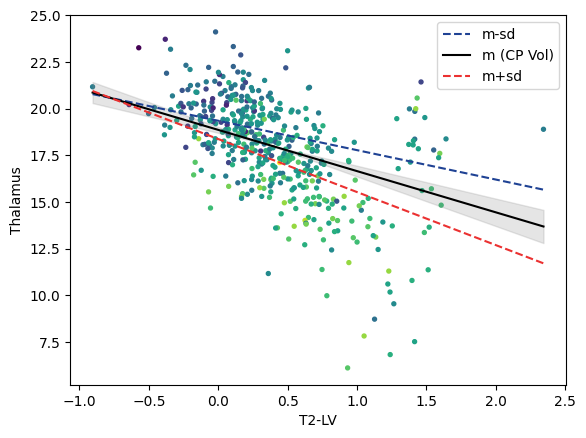

In [10]:
model_data = df.join([df_thomas])
# model_data = model_data[df_z['t2lv'] < 6]
model_data['choroid_cent'] = model_data['choroid_volume'] - model_data['choroid_volume'].mean()
model_data['t2lv_cent'] = model_data['t2lv_logtrans'] - model_data['t2lv_logtrans'].mean()

model_data = model_data[model_data['dz_type2'] == "MS"]
formula = "thalamus ~ choroid_cent*t2lv_cent + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()

x_rng, y_lvls = helpers.moderation_y(model_data, res, "t2lv_cent", "choroid_cent")
# fix x_rng since the moderation_y took the centered version
x_rng = np.linspace(model_data['t2lv_logtrans'].min(), model_data['t2lv_logtrans'].max(), 100)
# x_rng = np.linspace(0, 20, 100)


cmap = model_data['choroid_volume'] / model_data['choroid_volume'].max()
# helpers.plot_moderation(model_data['dzdur'], model_data['EDSS'], x_rng, y_lvls)
plt.scatter(model_data['t2lv_logtrans'], model_data['thalamus'], s=8, color=viridis(cmap))

# m-sd line
plt.plot(x_rng, y_lvls[0][0], label="m-sd", linestyle="--", color=colors['dark blue1'])
# plt.fill_between(x_rng, y_lvls[0][1], y_lvls[0][2], color=colors['light blue1'], alpha=0.1)

plt.plot(x_rng, y_lvls[1][0], label="m (CP Vol)", linestyle="-", color="black")
plt.fill_between(x_rng, y_lvls[1][1], y_lvls[1][2], color='grey', alpha=0.2)

plt.plot(x_rng, y_lvls[2][0], label="m+sd", linestyle="--", color=colors['dark red1'])
# plt.fill_between(x_rng, y_lvls[2][1], y_lvls[2][2], color=colors['light red1'], alpha=0.1)

plt.legend()
plt.xlabel("T2-LV")
plt.ylabel("Thalamus")
plt.show()
# print(res.summary())

### All Structures

#### MS Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS\n t2lv ~ struct + age + Female + tiv + choroid_volume'}, xlabel='dist', ylabel='coef'>)

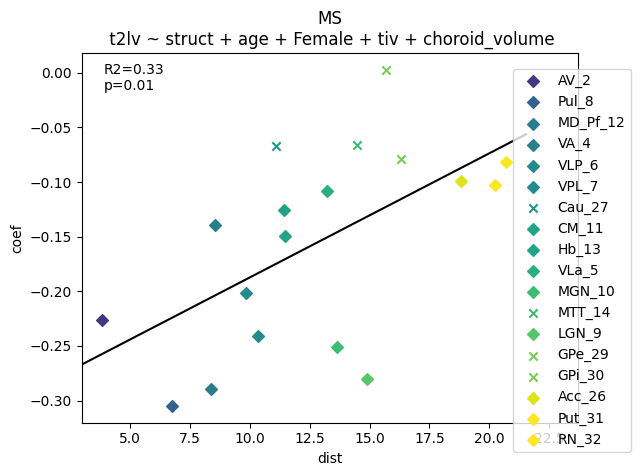

In [74]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv + choroid_volume"
outcome = "t2lv"

regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()
    data.loc[i, 'v_dist'] = ventricle_dists[str(i)].mean()
    # data.loc[i, 'dist'] = mni_choroid_dists.loc[0, str(i)]

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   title=f"MS\n {outcome} ~ struct + {covariates}")

Bootstrap

In [22]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type2'].isin(["MS"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_ms = np.zeros((n_boots,))
slopes_ms = np.zeros((n_boots,))
r_values_ms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_ms[i_samp] = (slope / std_err)
    slopes_ms[i_samp] = slope
    r_values_ms[i_samp]  = r_value

slopes_ms.sort()
mean_slope = slopes_ms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_ms[25], slopes_ms[975]))

r_values_ms.sort()
mean_r_value = r_values_ms.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_ms[25]**2, r_values_ms[975]**2))

p_boot = sum(t_stats_ms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.011 [0.0058, 0.019]
R2: 0.28 [0.15, 0.43]
Bootstrapped p: 0.00


#### PMS Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'PMS\n t2lv ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

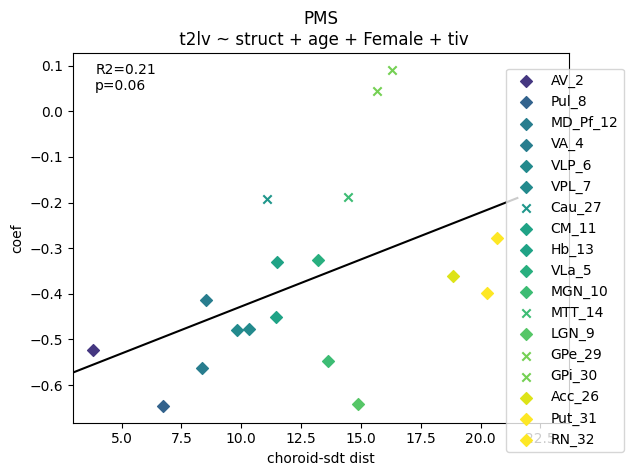

In [286]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "PMS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]

covariates = "age + Female + tiv"
outcome = "t2lv"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"PMS\n {outcome} ~ struct + {covariates}")

In [283]:
df_to_sample = model_data.copy() # copy over the model_data from above
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_pms = np.zeros((n_boots,))
slopes_pms = np.zeros((n_boots,))
r_values_pms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_pms[i_samp] = (slope / std_err)
    slopes_pms[i_samp] = slope
    r_values_pms[i_samp] = r_value

slopes_pms.sort()
mean_slope = slopes_pms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_pms[25], slopes_pms[975]))

r_values_pms.sort()
mean_r_value = r_values_pms.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_pms[25]**2, r_values_pms[975]**2))

p_boot = sum(t_stats_pms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.018 [0.008, 0.03]
R2: 0.14 [0.034, 0.3]
Bootstrapped p: 0.00


#### OIND Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'NIND\n choroid_volume ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

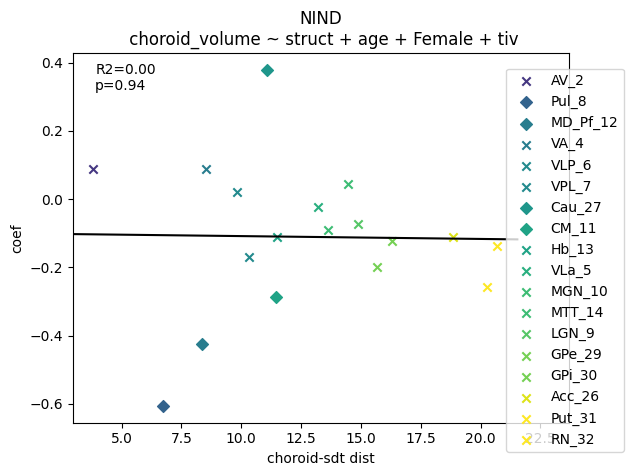

In [292]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "NIND"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"NIND\n {outcome} ~ struct + {covariates}")

In [288]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type5'].isin(["OIND"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_oind = np.zeros((n_boots,))
slopes_oind = np.zeros((n_boots,))
r_values_oind = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_oind[i_samp] = (slope / std_err)
    slopes_oind[i_samp] = slope
    r_values_oind[i_samp] = r_value

slopes_oind.sort()
mean_slope = slopes_oind.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_oind[25], slopes_oind[975]))

r_values_oind.sort()
mean_r_value = r_values_oind.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_oind[25]**2, r_values_oind[975]**2))

p_boot = sum(t_stats_oind <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.0049 [-0.014, 0.022]
R2: 4.5e-05 [0.4, 0.16]
Bootstrapped p: 0.35


### Thalamic Nuclei

#### MS Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS Patients\n CP ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

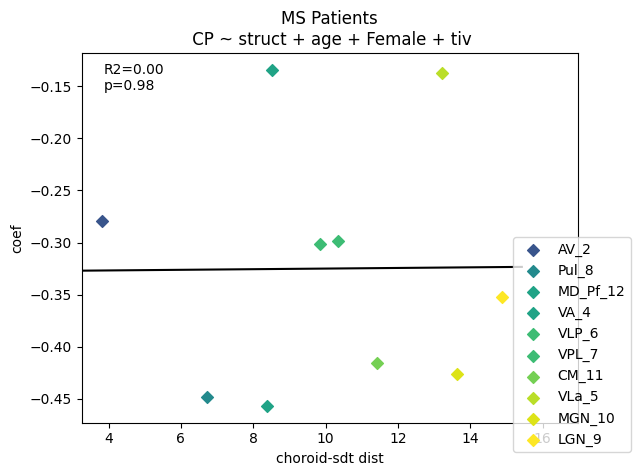

In [141]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = hips_thomas_ref.loc[thalamic_nuclei, 'struct_name']
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()
    # data.loc[i, 'dist'] = mni_choroid_dists.loc[0, str(i)]

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"MS Patients\n CP ~ struct + {covariates}")

Bootstrap

In [142]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type2'].isin(["MS"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_ms = np.zeros((n_boots,))
slopes_ms = np.zeros((n_boots,))
r_values_ms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_ms[i_samp] = (slope / std_err)
    slopes_ms[i_samp] = slope
    r_values_ms[i_samp]  = r_value

slopes_ms.sort()
mean_slope = slopes_ms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_ms[25], slopes_ms[975]))

r_values_ms.sort()
mean_r_value = r_values_ms.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_ms[25]**2, r_values_ms[975]**2))

p_boot = sum(t_stats_ms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.00022 [-0.0072, 0.0079]
R2: 4.2e-05 [0.04, 0.047]
Bootstrapped p: 0.47


#### PMS Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'PMS Patients\n CP ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

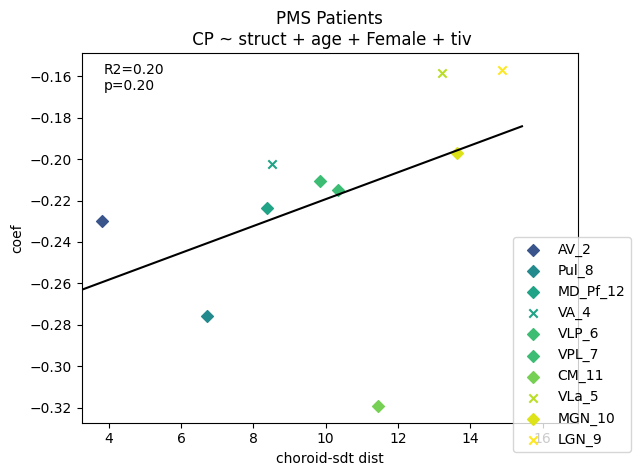

In [291]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "PMS"]
structs = hips_thomas_ref.loc[thalamic_nuclei, 'struct_name']
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"PMS Patients\n CP ~ struct + {covariates}")

PMS

In [144]:
df_to_sample = model_data.copy() # copy over the model_data from above
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_pms = np.zeros((n_boots,))
slopes_pms = np.zeros((n_boots,))
r_values_pms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_pms[i_samp] = (slope / std_err)
    slopes_pms[i_samp] = slope
    r_values_pms[i_samp] = r_value

slopes_pms.sort()
mean_slope = slopes_pms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_pms[25], slopes_pms[975]))

r_values_pms.sort()
mean_r_value = r_values_pms.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_pms[25]**2, r_values_pms[975]**2))

p_boot = sum(t_stats_pms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.0063 [-0.0058, 0.02]
R2: 0.088 [0.075, 0.59]
Bootstrapped p: 0.14


#### OIND Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'OIND\n CP ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

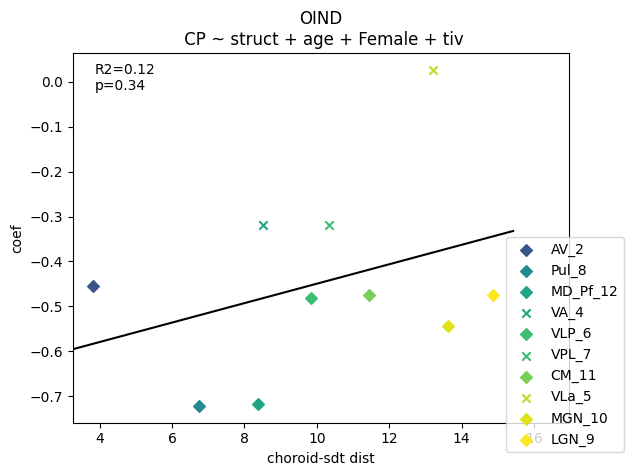

In [145]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "OIND"]
structs = hips_thomas_ref.loc[thalamic_nuclei, 'struct_name']
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"OIND\n CP ~ struct + {covariates}")

In [146]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type5'].isin(["OIND"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_oind = np.zeros((n_boots,))
slopes_oind = np.zeros((n_boots,))
r_values_oind = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_oind[i_samp] = (slope / std_err)
    slopes_oind[i_samp] = slope
    r_values_oind[i_samp] = r_value

slopes_oind.sort()
mean_slope = slopes_oind.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_oind[25], slopes_oind[975]))

r_values_oind.sort()
mean_r_value = r_values_oind.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_oind[25]**2, r_values_oind[975]**2))

p_boot = sum(t_stats_oind <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.032 [-0.0025, 0.078]
R2: 0.12 [0.0022, 0.47]
Bootstrapped p: 0.04


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS\n struct ~ cp*t2lv + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

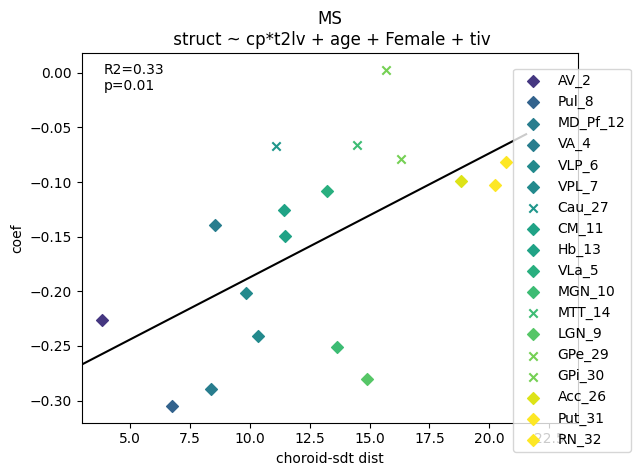

In [13]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
se = {}

if len(covariates) > 0:
    plus_covariates = f"+ {covariates}"
else:
    plus_covariates = ""
all_results = {}
for struct in structs:
    formula = f"{struct} ~ choroid_volume + t2lv {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues["t2lv"]
    coefs[struct] = res.params["t2lv"]
    se[struct] = res.HC0_se["t2lv"]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
# regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()
    # data.loc[i, 'dist'] = mni_choroid_dists.loc[0, str(i)]

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"MS\n struct ~ cp*t2lv + {covariates}")

In [81]:
from pyprocessmacro import Process

model_data = df_z.join([df_thomas_left_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=8, x="t2lv", y="EDSS", w="choroid_volume",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 8

Variables:
    Cons = Cons
    x = t2lv
    y = EDSS
    w = choroid_volume
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2645   0.2512 0.7721 22.7127    7  442   0.0000

Coefficients

                      coeff     se       t      p    LLCI    ULCI
Cons                -0.0384 0.0436 -0.8809 0.3788 -0.1240  0.0471
t2lv                 0.0181 0.0455  0.3974 0.6913 -0.0712  0.1074
choroid_volume      -0.0562 0.0506 -1.1093 0.2679 -0.1554  0.0431
t2lv*choro

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [87]:
from pyprocessmacro import Process

model_data = df_z.join([df_thomas_left_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=1, x="t2lv_logtrans", y="EDSS_sqrt", m="choroid_volume",
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 1

Variables:
    Cons = Cons
    x = t2lv_logtrans
    y = EDSS_sqrt
    m = choroid_volume
Statistical Controls:
 age, Female, tiv



Sample size:
468

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2411   0.2291 0.7878 23.4561    6  443   0.0000

Coefficients

                               coeff     se       t      p    LLCI    ULCI
Cons                         -0.0416 0.0454 -0.9166 0.3599 -0.1306  0.0474
t2lv_logtrans                 0.1351 0.0479  2.8193 0.0050  0.0412  0.2290
choroid_volume                0.0220 0.0497  0.4425 0.6584 -0.0754  0.1194
t2lv_logtrans*choroid_volume  0.0730 0.0420  1.7393 0.0827 -0.0093  0.1552
age                           0.4051 0.0466 

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(
